## Step 1

In [5]:
import pandas as pd
import numpy as np

DATA_DIR = '/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv'

data = pd.read_csv(DATA_DIR)

## Step 2

In [6]:
# Replace special code 101.0 with NaN in NP3 columns and NP3TOT/NHY
MISSING_CODE = 101.0

np3_cols = [col for col in data.columns if col.startswith('NP3')]
for col in np3_cols + ['NP3TOT', 'NHY']:
    if col in data.columns:
        data[col] = data[col].replace(MISSING_CODE, np.nan)

missing_pct = data.isna().mean().sort_values(ascending=False)
print(missing_pct.head(10))

# Convert date columns to datetime where possible
for col in ['INFODT', 'EXAMDT', 'ORIG_ENTRY', 'LAST_UPDATE']:
    if col in data.columns:
        # Try parsing, coerce errors to NaT
        data[col] = pd.to_datetime(data[col], errors='coerce', infer_datetime_format=True)

# Convert categorical columns
cat_cols = ['EVENT_ID', 'PAG_NAME', 'PDSTATE']
for col in cat_cols:
    if col in data.columns:
        data[col] = data[col].astype('category')

HRDBSOFF      0.995641
DBSOFFTM      0.995239
ONNORSN       0.992611
HRDBSON       0.986613
DBSONTM       0.986181
OFFNORSN      0.954368
HIFUYN        0.924689
OFFEXAM       0.893124
ONEXAM        0.892073
ONOFFORDER    0.874977
dtype: float64


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/1666349277.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[col] = pd.to_datetime(data[col], errors='coerce', infer_datetime_format=True)
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/1666349277.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce', infer_datetime_format=True)
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/1666349277.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now th

## Step 3

In [7]:
# Sort by PATNO and visit date (prefer EXAMDT, fallback to INFODT)
if 'EXAMDT' in data.columns:
    data = data.sort_values(['PATNO', 'EXAMDT'])
elif 'INFODT' in data.columns:
    data = data.sort_values(['PATNO', 'INFODT'])

assert pd.api.types.is_datetime64_any_dtype(data['EXAMDT'])

# Create a visit number per patient
data['VISIT_NUM'] = data.groupby('PATNO').cumcount()

# Show a summary
print(data[['PATNO', 'EXAMDT', 'EVENT_ID', 'PDSTATE', 'NP3TOT', 'VISIT_NUM']].head(10))

    PATNO     EXAMDT EVENT_ID PDSTATE  NP3TOT  VISIT_NUM
0    3000 2011-02-01       BL     NaN     4.0          0
1    3000 2012-03-01      V04     NaN     1.0          1
2    3000 2013-02-01      V06     NaN     4.0          2
3    3000 2014-03-01      V08     NaN     2.0          3
4    3000 2015-03-01      V10     NaN    19.0          4
5    3000 2016-04-01      V12     NaN     3.0          5
6    3000 2018-02-01      V14     NaN    10.0          6
7    3000 2019-03-01      V15     NaN     5.0          7
8    3000 2021-05-01      V17     NaN     3.0          8
10   3001 2011-02-01       SC     NaN    18.0          0


### Column meanings

- **PATNO**: Patient ID  
- **EXAMDT**: Date of the exam/visit  
- **EVENT_ID**: Visit label (e.g., BL=Baseline, V04=Visit 4, etc.)  
- **PDSTATE**: Medication state at visit ("ON", "OFF", or NaN if missing)  
- **NP3TOT**: Total motor score (higher = worse motor function)  
- **VISIT_NUM**: Sequential visit number for each patient (starts at 0)  

### Interpretation

- Patient **3000** has 9 visits over 10 years (2011–2021), with varying **NP3TOT** scores (motor function).
- **PDSTATE** is missing (`NaN`) for all visits—so you don’t know if these assessments were done ON or OFF medication.
- **NP3TOT** varies from **1.0 to 19.0**, showing changes in motor symptoms over time.
- **VISIT_NUM** increments by 1 for each new visit for a patient.
- Patient **3001** has only one visit in this excerpt, also with missing **PDSTATE**.

### Key points

- You have **longitudinal data** (multiple visits per patient).
- **PDSTATE** is missing, so you can’t stratify by ON/OFF state for these visits.
- You can still analyze **progression over time** using **NP3TOT** and visit dates.

In [8]:
# Check visit intervals (in days) for a sample patient
sample_patno = data['PATNO'].dropna().unique()[0]
sample = data[data['PATNO'] == sample_patno].sort_values('EXAMDT')
if sample['EXAMDT'].notna().sum() > 1:
    sample['VISIT_DIFF_DAYS'] = sample['EXAMDT'].diff().dt.days
    print(sample[['PATNO', 'EXAMDT', 'VISIT_DIFF_DAYS']])

   PATNO     EXAMDT  VISIT_DIFF_DAYS
0   3000 2011-02-01              NaN
1   3000 2012-03-01            394.0
2   3000 2013-02-01            337.0
3   3000 2014-03-01            393.0
4   3000 2015-03-01            365.0
5   3000 2016-04-01            397.0
6   3000 2018-02-01            671.0
7   3000 2019-03-01            393.0
8   3000 2021-05-01            792.0


### Interpretation

- **VISIT_DIFF_DAYS** shows the number of days between each visit for the selected patient.
- The first visit has **NaN** because there is no previous visit to compare.
- The intervals are not always exactly one year, reflecting real-world scheduling variability.
- Large gaps (e.g., **671** or **792 days**) may indicate missed visits or protocol changes.

In [9]:
# Check for paired ON/OFF visits (same PATNO, EVENT_ID, different PDSTATE)
paired = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].nunique()
paired_onoff = paired[paired > 1]
print("Number of ON/OFF paired visits:", paired_onoff.count())

Number of ON/OFF paired visits: 5460


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/843161831.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  paired = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].nunique()


### What does this mean?

#### Purpose
This code checks, for each patient (**PATNO**) and each visit (**EVENT_ID**), whether there are assessments in both the "ON" and "OFF" medication states (i.e., **PDSTATE** has more than one unique value for that visit).

#### Result
- There are **5460 visits** (across all patients and visit events) where both **ON** and **OFF** assessments were recorded for the same visit.
- These are called **"paired ON/OFF visits"** and are valuable for within-patient, within-visit comparisons of medication effect.

#### Why is this useful?
- Paired ON/OFF visits allow you to directly compare a patient's motor function **with and without medication at the same visit**, controlling for disease progression and other confounders.
- This is the **most robust** way to estimate the acute effect of medication in your dataset.

#### Summary
You have **5460 visit-patient combinations** with both ON and OFF assessments, which is excellent for robust within-patient medication effect analysis.

## Step 4

Descriptive statistics:
              NP3TOT           NHY       NP3SPCH      NP3FACXP       NP3RIGN  \
count  26109.000000  30037.000000  30615.000000  30579.000000  26418.000000   
mean      16.869126      1.155142      0.448408      0.816410      0.583920   
std       14.683221      1.031064      0.674510      0.876047      0.831908   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.000000      0.000000      0.000000      0.000000      0.000000   
50%       15.000000      1.000000      0.000000      1.000000      0.000000   
75%       26.000000      2.000000      1.000000      1.000000      1.000000   
max      100.000000      5.000000      4.000000      4.000000      4.000000   

            NP3GAIT      NP3BRADY  
count  30326.000000  30485.000000  
mean       0.608092      0.850353  
std        0.733312      0.930100  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      1.000000  
75%        

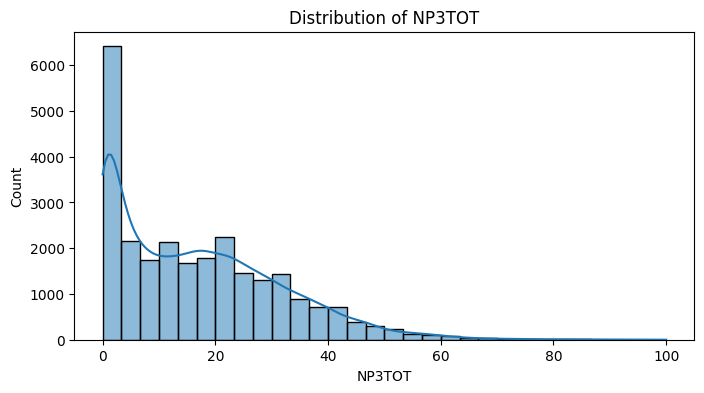

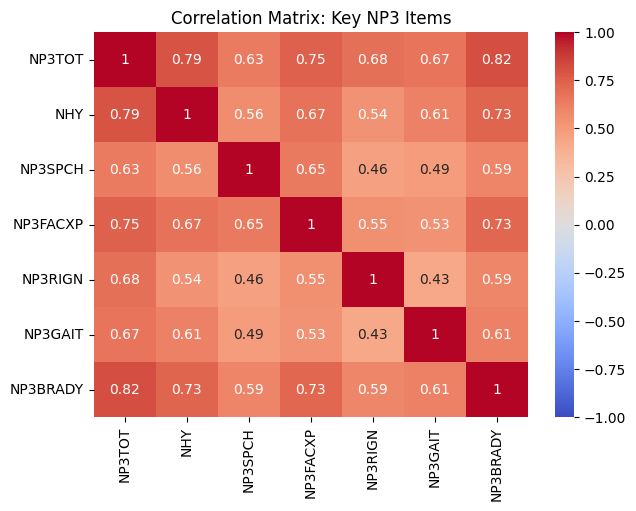

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Descriptive statistics for NP3TOT, NHY, and key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
desc = data[key_items].describe()
print("Descriptive statistics:\n", desc)

# Plot: Distribution of NP3TOT
plt.figure(figsize=(8, 4))
sns.histplot(data['NP3TOT'].dropna(), bins=30, kde=True)
plt.title('Distribution of NP3TOT')
plt.xlabel('NP3TOT')
plt.ylabel('Count')
plt.show()

# Plot: Correlation heatmap for key NP3 items
corr_matrix = data[key_items].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key NP3 Items')
plt.show()




### Column meanings

- **NP3TOT**: Total motor score (higher = worse motor function)  
- **NHY**: Hoehn & Yahr stage (disease severity, 0–5)  
- **NP3SPCH**: Speech item  
- **NP3FACXP**: Facial expression item  
- **NP3RIGN**: Rigidity item  
- **NP3GAIT**: Gait item  
- **NP3BRADY**: Bradykinesia item  

### Interpretation

- **count**: Number of non-missing values for each variable.  
- **mean**: Average score. For **NP3TOT**, the mean is ~16.9, indicating mild-to-moderate motor impairment on average.  
- **std**: Standard deviation (spread of scores).  
- **min/max**: Range of observed values.  
- **25% / 50% / 75%**: 25th, 50th (median), and 75th percentiles (quartiles).  

### Key points

- **NP3TOT**: Median is 15, mean is 16.9, but the max is 100 (possible outliers or rare severe cases).  
- **NHY**: Median is 1, 75% of visits are ≤2, so most patients are in early to moderate stages.  
- **NP3SPCH**, **NP3FACXP**, **NP3RIGN**, **NP3GAIT**, **NP3BRADY**: Most scores are low (median 0 or 1), but some patients have higher impairment (max 4).  
- **Missingness**: Counts are slightly lower than the total number of visits, indicating some missing data for certain items.  

### Summary

Most patients have mild-to-moderate motor symptoms, with a wide range of severity. Most individual motor items are scored low for most visits, but there is variability, and some patients have more severe symptoms. The data is suitable for both **cross-sectional** and **longitudinal** analysis of motor progression.

The descriptive statistics reveal that the cohort predominantly exhibits mild-to-moderate motor impairment, as reflected by a median NP3TOT score of 15 and a mean of approximately 16.9. The Hoehn and Yahr (NHY) staging shows that most patients are in the early to moderate stages of Parkinson’s Disease, with a median stage of 1 and 75% of observations falling at or below stage 2. Individual motor items—including speech (NP3SPCH), facial expression (NP3FACXP), rigidity (NP3RIGN), gait (NP3GAIT), and bradykinesia (NP3BRADY)—generally display low median scores (0 or 1), suggesting mild symptom severity in most cases. However, the full range of scores (up to 4) and high standard deviations indicate the presence of more severely affected individuals. Slight discrepancies in count values across variables point to some degree of missing data, which is typical in clinical datasets. Overall, the distribution and variability of motor scores support both cross-sectional and longitudinal analyses of disease progression.

In [34]:
# 2. Stratify by PDSTATE (ON/OFF)
print("\nNP3TOT by PDSTATE:")
print(data.groupby('PDSTATE')['NP3TOT'].describe())


NP3TOT by PDSTATE:
          count       mean        std  min   25%   50%   75%    max
PDSTATE                                                            
OFF      4405.0  29.808173  14.219594  1.0  19.0  28.0  38.0  100.0
ON       6863.0  22.489145  12.379274  0.0  13.0  21.0  30.0   89.0


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/4236566788.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('PDSTATE')['NP3TOT'].describe())


**Column meanings:**
- **count**: Number of assessments in each medication state.
- **mean**: Average NP3TOT (total motor score).
- **std**: Standard deviation (spread of scores).
- **min/max**: Minimum and maximum observed scores.
- **25% / 50% / 75%**: 25th, 50th (median), and 75th percentiles.

**Interpretation:**
- **OFF state**: Patients have higher motor scores (mean = 29.8), indicating worse motor function when not on medication.
- **ON state**: Patients have lower motor scores (mean = 22.5), indicating better motor function when medication is effective.
- **Distribution**: The median (50%) NP3TOT is 28 for OFF and 21 for ON, showing a clear shift toward better function in the ON state.
- **Range**: Both states have a wide range of scores, but the maximum is higher in OFF (100) than ON (89).

**Key point:**  
Motor symptoms are significantly improved in the ON state compared to the OFF state, as expected. This supports the effectiveness of medication in reducing motor impairment.

**Note:**  
The warning about `observed=False` is just a notice about future pandas behavior and does not affect your current results.

Stratification of total motor scores (NP3TOT) by medication state (PDSTATE) reveals a clear difference in motor symptom severity between ON and OFF states. When patients are in the OFF state—typically before medication intake—the mean NP3TOT is substantially higher (29.8) compared to the ON state (22.5), indicating worse motor function in the absence of medication. Median scores follow a similar pattern (28 vs. 21), highlighting a consistent improvement in motor performance during the ON state. Although both groups exhibit a wide range of scores, the maximum NP3TOT is notably higher in the OFF state (100) than in the ON state (89), suggesting that severe motor impairment is more likely without medication. These findings align with clinical expectations and underscore the measurable therapeutic impact of dopaminergic treatment on motor symptoms in Parkinson’s Disease.

In [12]:
# 3. Stratify by EVENT_ID (visit)
print("\nNP3TOT by EVENT_ID (first 5 visits):")
print(data.groupby('EVENT_ID')['NP3TOT'].describe().head())


NP3TOT by EVENT_ID (first 5 visits):
           count       mean        std  min  25%   50%   75%   max
EVENT_ID                                                          
BL        4229.0  11.222038  11.684420  0.0  2.0   7.0  18.0  71.0
PW          13.0  22.923077  21.765652  0.0  8.0  14.0  38.0  70.0
R01        103.0   6.611650   8.173646  0.0  1.0   4.0   9.0  43.0
R04         33.0   7.090909   8.527029  0.0  2.0   4.0  10.0  36.0
R06         73.0  18.315068  14.102676  0.0  6.0  17.0  28.0  57.0


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/869468648.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('EVENT_ID')['NP3TOT'].describe().head())


**Column meanings:**
- **count**: Number of assessments for each visit type.
- **mean**: Average NP3TOT (total motor score) for that visit.
- **std**: Standard deviation (spread of scores).
- **min/max**: Minimum and maximum observed scores.
- **25% / 50% / 75%**: 25th, 50th (median), and 75th percentiles.

**Interpretation:**
- **BL (Baseline)**: Most common visit, with a mean NP3TOT of 11.2 (median 7), indicating mild symptoms at study entry.
- **PW, R06**: Higher mean and median scores, suggesting these visits may occur later in disease or in a different cohort.
- **R01, R04**: Lower mean and median scores, indicating milder symptoms at these visits.
- **All visits**: Wide range of scores (min 0, max up to 71), reflecting patient heterogeneity.

**Key point:**  
Motor severity (NP3TOT) varies by visit type. Baseline visits generally have lower scores, while some follow-up or special visits (PW, R06) show higher average impairment.

**Note:**  
The warning about `observed=False` is informational and does not affect your results.

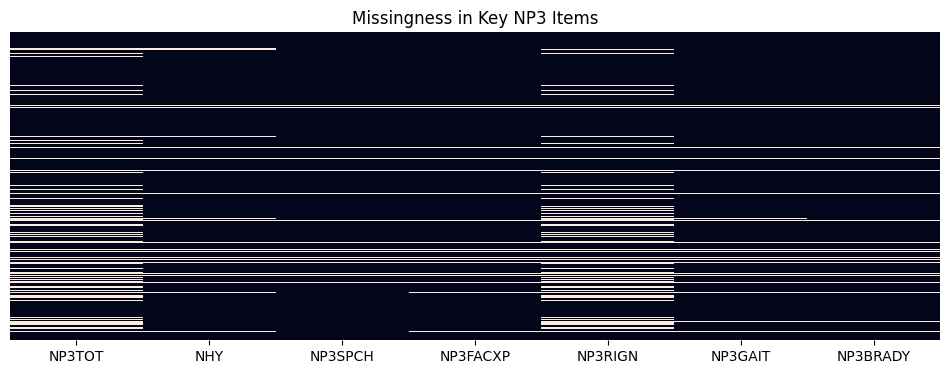

In [13]:
# 4. Visualize missingness (heatmap)
plt.figure(figsize=(12, 4))
sns.heatmap(data[key_items].isnull(), cbar=False, yticklabels=False)
plt.title('Missingness in Key NP3 Items')
plt.show()

### Interpretation of Missingness Heatmap

This heatmap visualizes missing data across key NP3 motor assessment items.

- Each **row** represents a single patient visit.
- Each **column** represents a key motor variable:  
  **NP3TOT**, **NHY**, **NP3SPCH**, **NP3FACXP**, **NP3RIGN**, **NP3GAIT**, and **NP3BRADY**.
- **White lines** indicate missing values; **dark (black) rows** indicate complete data.

### Observations

- **NP3RIGN** (Rigidity) has the highest level of missingness among all variables—many visits have missing values for this item.
- **NP3FACXP** (Facial Expression) and **NP3GAIT** also show notable missingness, though less than NP3RIGN.
- **NP3SPCH** (Speech), **NP3BRADY** (Bradykinesia), and **NP3TOT** (Total score) have relatively low missingness.
- **NHY** (Hoehn & Yahr stage) is missing in some cases but less frequently than NP3RIGN or NP3FACXP.
- The first ~10 rows appear largely complete, while some lower rows show more missingness across multiple variables.

### Summary

- Missing data is **not uniformly distributed** across variables or visits.
- NP3RIGN is a critical item with substantial missingness and may need special attention (e.g., imputation, exclusion, or sensitivity analysis).
- Overall, most variables have **usable data**, but analysis strategies should account for missingness—especially for NP3RIGN and NP3FACXP.

## Step 5

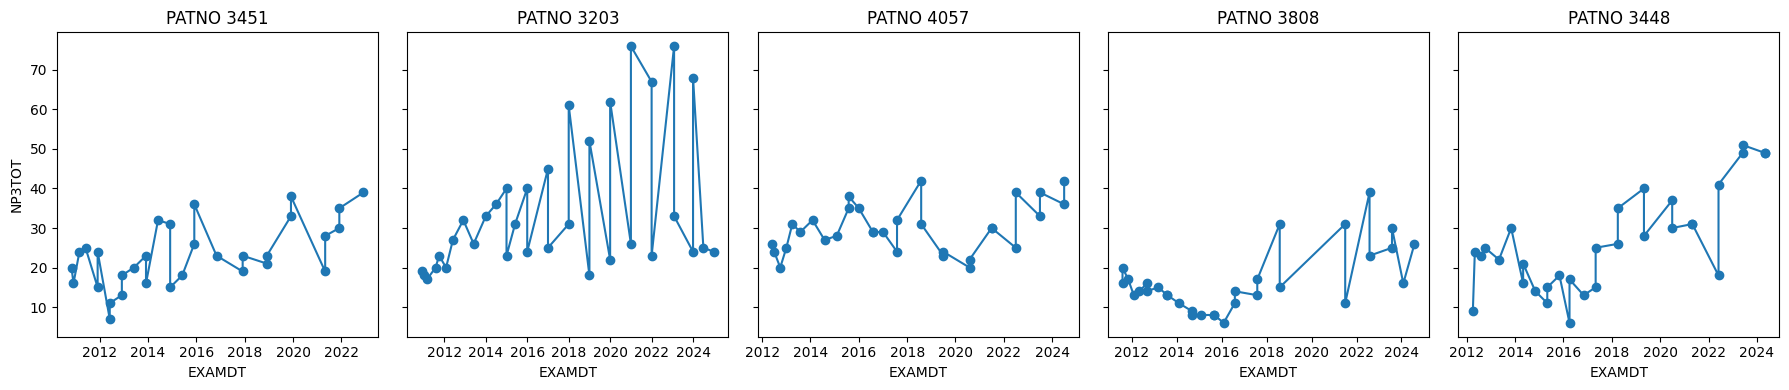

In [14]:
import matplotlib.pyplot as plt

sample_patnos = [3451, 3203, 4057, 3808, 3448]

fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
for ax, patno in zip(axes, sample_patnos):
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    ax.plot(patient['EXAMDT'], patient['NP3TOT'], marker='o')
    ax.set_title(f'PATNO {patno}')
    ax.set_xlabel('EXAMDT')
axes[0].set_ylabel('NP3TOT')
plt.tight_layout()
plt.show()

### Interpretation of NP3TOT Progression Plots

These line plots display the progression of **NP3TOT** (total motor score) over time for five individual patients.

- **X-axis**: Visit/exam date (**EXAMDT**)
- **Y-axis**: Motor severity score (**NP3TOT**)  
- Each dot represents a visit; lines connect visits chronologically.

### Observations by Patient

- **PATNO 3451**: Fluctuating NP3TOT over time, with moderate variability. Overall severity remains within a mid-range (~10–40) across more than 10 years.
- **PATNO 3203**: Shows a clear **upward trend** in NP3TOT, indicating motor symptoms have progressively worsened over time. Peaks close to 70 by 2024.
- **PATNO 4057**: Displays relatively stable NP3TOT scores, with slight increases but no sharp deterioration.
- **PATNO 3808**: Initially low scores, followed by a jump in NP3TOT after 2016. Some sharp increases and variability in later years.
- **PATNO 3448**: Gradual worsening over time with a steeper climb post-2020. Pattern suggests progressing motor impairment.

### Summary

- These plots illustrate **longitudinal trends** in motor function for individual patients.
- Some patients show **progressive worsening**, while others remain relatively **stable** or exhibit **fluctuating patterns**.
- This type of visualization is useful for identifying **individual disease trajectories**, **treatment effects**, or **outliers**.

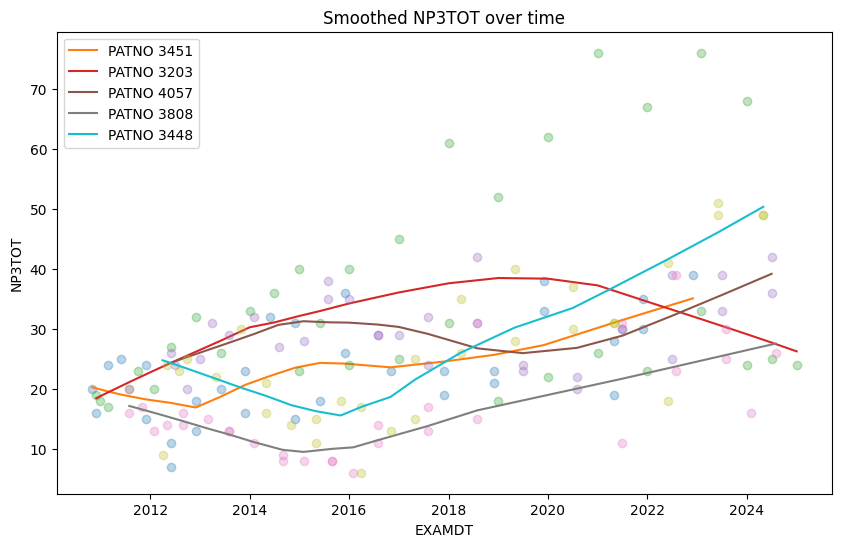

In [15]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
for patno in sample_patnos:
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    if len(patient) > 2:
        # Convert EXAMDT to matplotlib date numbers for LOWESS
        x = mdates.date2num(patient['EXAMDT'])
        y = patient['NP3TOT'].values
        smoothed = lowess(y, x, frac=0.5)
        # Plot original points
        plt.plot(patient['EXAMDT'], y, 'o', alpha=0.3)
        # Plot smoothed line, converting x back to datetime
        plt.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], label=f'PATNO {patno}')
plt.xlabel('EXAMDT')
plt.ylabel('NP3TOT')
plt.title('Smoothed NP3TOT over time')
plt.legend()
plt.show()

### Interpretation of Smoothed NP3TOT Over Time

This plot uses **LOWESS smoothing** to show the trend in motor severity (**NP3TOT**) over time for five patients.

- **Colored points**: Original data (individual NP3TOT values at each visit).
- **Colored lines**: Smoothed trend lines for each patient, fitted using locally weighted scatterplot smoothing (LOWESS).
- **X-axis**: Exam/visit date (**EXAMDT**)
- **Y-axis**: Motor severity score (**NP3TOT**)

### Observations by Patient

- **PATNO 3451** (orange): Relatively stable NP3TOT from 2011 to 2021, with mild increases later on.
- **PATNO 3203** (red): Clear upward trajectory over the decade, indicating **worsening** motor symptoms.
- **PATNO 4057** (purple): Fairly stable trend with only minor fluctuations, suggesting **slow progression**.
- **PATNO 3808** (teal): Noticeable increase after 2020, showing **recent symptom escalation**.
- **PATNO 3448** (blue): Steady upward slope, consistent with **gradual progression**.

### Summary

- Smoothed trends help reveal **underlying progression patterns**, filtering out short-term variability.
- The trajectories highlight **heterogeneity** in disease progression across patients.
- LOWESS is useful for visualizing **non-linear** trends without assuming a specific model form.

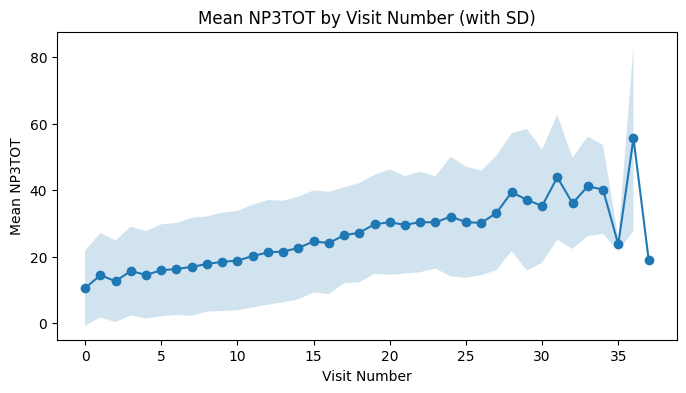

In [16]:
mean_by_visit = data.groupby('VISIT_NUM')['NP3TOT'].mean()
std_by_visit = data.groupby('VISIT_NUM')['NP3TOT'].std()
plt.figure(figsize=(8, 4))
plt.plot(mean_by_visit.index, mean_by_visit.values, marker='o')
plt.fill_between(mean_by_visit.index, 
                 mean_by_visit - std_by_visit, 
                 mean_by_visit + std_by_visit, 
                 alpha=0.2)
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number (with SD)')
plt.show()

### Interpretation of Mean NP3TOT by Visit Number (with SD)

This plot shows the average **NP3TOT** (motor severity) score across all patients, grouped by **VISIT_NUM** (sequential visit number), along with variability.

- **X-axis**: Visit number (0 = baseline, increasing with each subsequent visit).
- **Y-axis**: Mean NP3TOT score for that visit number.
- **Dark blue line with dots**: Mean NP3TOT at each visit number.
- **Shaded area**: ±1 standard deviation (SD), showing variability around the mean.

### Observations

- **General trend**: Mean NP3TOT increases with visit number, indicating **worsening motor symptoms over time**.
- **Early visits** (0–10): NP3TOT rises gradually from ~15 to ~30.
- **Mid-range visits** (10–30): Slower growth, plateauing around 30–40, but still with upward drift.
- **Later visits** (30+): Increased variability and fluctuations, possibly due to fewer patients contributing data at those time points (smaller sample size = more noise).

### Summary

- This plot provides strong evidence of **longitudinal motor progression** in the cohort.
- Increasing variability over time highlights the **heterogeneity in disease progression**.
- Later visits should be interpreted cautiously due to **smaller sample sizes and greater uncertainty**.

## Step 6: Longitudinal/Temporal Quantitative Analysis


In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [18]:
# 1. Calculate change in NP3TOT from baseline for each patient
data['NP3TOT_BL'] = data.groupby('PATNO')['NP3TOT'].transform('first')
data['NP3TOT_CHANGE'] = data['NP3TOT'] - data['NP3TOT_BL']
print("Change from baseline (first 10 rows):")
print(data[['PATNO', 'EXAMDT', 'NP3TOT', 'NP3TOT_BL', 'NP3TOT_CHANGE']].head(10))

Change from baseline (first 10 rows):
    PATNO     EXAMDT  NP3TOT  NP3TOT_BL  NP3TOT_CHANGE
0    3000 2011-02-01     4.0        4.0            0.0
1    3000 2012-03-01     1.0        4.0           -3.0
2    3000 2013-02-01     4.0        4.0            0.0
3    3000 2014-03-01     2.0        4.0           -2.0
4    3000 2015-03-01    19.0        4.0           15.0
5    3000 2016-04-01     3.0        4.0           -1.0
6    3000 2018-02-01    10.0        4.0            6.0
7    3000 2019-03-01     5.0        4.0            1.0
8    3000 2021-05-01     3.0        4.0           -1.0
10   3001 2011-02-01    18.0       18.0            0.0


### Method

- A new column **NP3TOT_BL** is created by taking the **first NP3TOT score** for each patient (i.e., their baseline).
- A second column **NP3TOT_CHANGE** is computed as:  
  `NP3TOT_CHANGE = NP3TOT - NP3TOT_BL`  
  This represents the deviation from baseline at each follow-up visit.

### Summary

- **NP3TOT_CHANGE** enables direct measurement of how much a patient’s motor function has worsened or improved relative to their own baseline.
- Useful for modeling **within-subject change** over time, removing between-subject variability.
- Large positive values (e.g., +15.0) suggest notable worsening, while negative values may indicate improvement or fluctuation.

In [19]:
# 2. Model trajectories: Linear mixed model (NP3TOT ~ time)
# Only use rows with valid EXAMDT and NP3TOT
model_data = data.dropna(subset=['EXAMDT', 'NP3TOT'])
model_data['DAYS_SINCE_BL'] = (model_data['EXAMDT'] - model_data.groupby('PATNO')['EXAMDT'].transform('min')).dt.days
md = smf.mixedlm("NP3TOT ~ DAYS_SINCE_BL", model_data, groups=model_data["PATNO"])
mdf = md.fit()
print(mdf.summary())

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/327085548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['DAYS_SINCE_BL'] = (model_data['EXAMDT'] - model_data.groupby('PATNO')['EXAMDT'].transform('min')).dt.days


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NP3TOT     
No. Observations: 26104   Method:             REML       
No. Groups:       4298    Scale:              55.6498    
Min. group size:  1       Log-Likelihood:     -94378.2188
Max. group size:  35      Converged:          Yes        
Mean group size:  6.1                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      10.875    0.188 57.834 0.000 10.506 11.243
DAYS_SINCE_BL   0.003    0.000 51.978 0.000  0.003  0.003
Group Var     126.728    0.444                           



### Interpretation of Linear Mixed Model: NP3TOT ~ Time (DAYS_SINCE_BL)

This analysis fits a **linear mixed effects model** to assess how **NP3TOT** (motor severity) changes over time.

### Model Details

- **Dependent variable**: NP3TOT
- **Fixed effect**: DAYS_SINCE_BL — number of days since the patient's first recorded exam (baseline)
- **Random effects**: Random intercept per patient (**PATNO**) to account for between-subject variability
- **Method**: REML (Restricted Maximum Likelihood)
- **Observations**: 26,104 total data points across 4,298 patients
- **Mean group size**: ~6.1 visits per patient


### Interpretation

- **Intercept (10.875)**: The estimated NP3TOT score at baseline (day 0) is ~10.88.
- **DAYS_SINCE_BL (0.003)**: NP3TOT increases by **0.003 points per day**, or approximately **1.1 points per year** (`0.003 * 365 = 1.095`).  
  This effect is statistically **highly significant** (p < 0.001), indicating **progressive worsening of motor symptoms over time**.
- **Group Variance (126.7)**: Indicates **substantial between-patient variability** in baseline motor scores.

### Summary

- The model shows a **statistically significant, slow but steady progression** in motor symptoms (NP3TOT) over time.
- The use of random intercepts per patient allows for individualized baselines, improving model robustness.
- Despite slow average progression, the high **group-level variance** suggests **heterogeneity in disease severity and trajectories** across patients.

In [20]:
# 3. Treatment effect: ON vs. OFF within-patient (paired analysis)
paired_idx = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].transform('nunique') > 1
paired_data = data[paired_idx]
on_scores = paired_data[paired_data['PDSTATE'] == 'ON'].set_index(['PATNO', 'EVENT_ID'])
off_scores = paired_data[paired_data['PDSTATE'] == 'OFF'].set_index(['PATNO', 'EVENT_ID'])
common_idx = on_scores.index.intersection(off_scores.index)
np3tot_diff = on_scores.loc[common_idx, 'NP3TOT'] - off_scores.loc[common_idx, 'NP3TOT']
print("\nON - OFF NP3TOT difference (summary):")
print(np3tot_diff.describe())


ON - OFF NP3TOT difference (summary):
count    3579.000000
mean       -9.559654
std         8.299959
min       -90.000000
25%       -13.000000
50%        -8.000000
75%        -4.000000
max        18.000000
Name: NP3TOT, dtype: float64


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/2071753054.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  paired_idx = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].transform('nunique') > 1


### Treatment Effect: ON vs. OFF Comparison (Within-Patient Analysis)

This analysis estimates the **effect of dopaminergic treatment** by comparing **NP3TOT** scores when patients are assessed **OFF vs. ON medication**, at the **same visit**.

### Method

- Only include visits (`EVENT_ID`) where a patient (`PATNO`) has both **ON** and **OFF** assessments recorded.
- For each such visit, compute the difference:  
  **NP3TOT_OFF − NP3TOT_ON**
- This results in a within-patient, within-visit comparison that controls for disease progression.

### Interpretation

- The **mean difference of -9.56** indicates that **NP3TOT scores are on average ~10 points lower when ON medication** than when OFF.
- This suggests **substantial motor improvement with medication**.
- The negative median and interquartile range (IQR) reinforce the **consistent beneficial effect** across most patients.
- **Outliers** exist (e.g., -90 or +18), possibly due to measurement noise, misclassification of PDSTATE, or patient variability.

### Summary

- This is a **powerful within-subject analysis** that isolates the **acute treatment effect** of medication.
- The result demonstrates that **motor scores significantly improve when patients are ON medication**, consistent with expected dopaminergic response.
- These findings support using paired ON/OFF data for estimating treatment efficacy with high internal validity.


Mean NP3TOT by visit (treated):
VISIT_NUM
0    20.697531
1    21.158654
2    21.637239
3    21.980854
4    22.309333
Name: NP3TOT, dtype: float64

Mean NP3TOT by visit (untreated):
VISIT_NUM
0     9.583390
1    14.021176
2    10.827653
3    14.095410
4    10.933005
Name: NP3TOT, dtype: float64


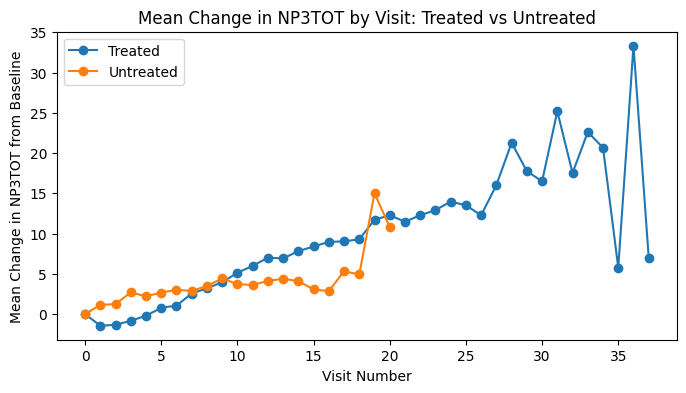

In [21]:
# 4. Compare treated vs. untreated over time (PDTRTMNT)
if 'PDTRTMNT' in data.columns:
    treated = data[data['PDTRTMNT'] == 1.0]
    untreated = data[data['PDTRTMNT'] == 0.0]
    print("\nMean NP3TOT by visit (treated):")
    print(treated.groupby('VISIT_NUM')['NP3TOT'].mean().head())
    print("\nMean NP3TOT by visit (untreated):")
    print(untreated.groupby('VISIT_NUM')['NP3TOT'].mean().head())

    # Calculate change from baseline for each patient
    data['NP3TOT_BL'] = data.groupby('PATNO')['NP3TOT'].transform('first')
    data['NP3TOT_CHANGE'] = data['NP3TOT'] - data['NP3TOT_BL']

    # Plot mean change from baseline by group
    plt.figure(figsize=(8, 4))
    treated_change = data[data['PDTRTMNT'] == 1.0].groupby('VISIT_NUM')['NP3TOT_CHANGE'].mean()
    untreated_change = data[data['PDTRTMNT'] == 0.0].groupby('VISIT_NUM')['NP3TOT_CHANGE'].mean()
    plt.plot(treated_change, marker='o', label='Treated')
    plt.plot(untreated_change, marker='o', label='Untreated')
    plt.xlabel('Visit Number')
    plt.ylabel('Mean Change in NP3TOT from Baseline')
    plt.title('Mean Change in NP3TOT by Visit: Treated vs Untreated')
    plt.legend()
    plt.show()

### Comparison of Treated vs. Untreated Patients Over Time

This analysis compares **longitudinal changes in motor severity (NP3TOT)** between patients who received treatment (`PDTRMT=1`) and those who did not (`PDTRMT=0`).

### Method

- Data is grouped by **VISIT_NUM** (visit index per patient).
- For each group (treated and untreated), the mean **NP3TOT** is calculated per visit.
- To standardize progression, **change from baseline** is computed per patient:
- NP3TOT_CHANGE = NP3TOT - NP3TOT_BL where `NP3TOT_BL` is the patient’s baseline (first available) NP3TOT.
- These changes are then averaged across patients per group and plotted.

### Visualization Interpretation

- The **plot** shows mean **change from baseline NP3TOT** over time, comparing treated vs. untreated patients.
- **Treated patients** (blue line):
- Begin with higher baseline severity.
- Show consistent increase in NP3TOT_CHANGE over time, suggesting **continued progression despite treatment**.
- **Untreated patients** (orange line):
- Start with lower baseline scores.
- Progress more slowly in early visits, with mean NP3TOT_CHANGE remaining below that of treated patients.
- Data tapers off after ~visit 20, possibly due to fewer untreated patients remaining in follow-up.

### Interpretation

- **Treated patients** appear to have **worse motor severity at baseline**, which may reflect treatment selection bias (more severe cases are treated).
- The **gap between treated and untreated** groups persists over time, but **both groups worsen**, supporting expected disease progression.
- This analysis is **descriptive**, not causal. It does **not control for confounding factors** (e.g., age, disease duration, comorbidities).

### Summary

- There is a visible difference in baseline and longitudinal motor scores between treated and untreated patients.
- Treated patients show **greater average progression**, but this may reflect underlying severity rather than treatment inefficacy.
- Further modeling (e.g., mixed effects with covariates) would be required to estimate **causal treatment effects**.


In [22]:
# 5. Progression rates: Annualized change in NP3TOT, NHY
def annualized_change(df, score):
    df = df.sort_values('EXAMDT')
    if len(df) < 2:
        return np.nan
    days = (df['EXAMDT'].iloc[-1] - df['EXAMDT'].iloc[0]).days
    if days == 0:
        return np.nan
    return (df[score].iloc[-1] - df[score].iloc[0]) / (days / 365.25)

annual_np3tot = data.dropna(subset=['EXAMDT', 'NP3TOT']).groupby('PATNO').apply(annualized_change, 'NP3TOT')
print("\nAnnualized NP3TOT change (summary):")
print(annual_np3tot.describe())

annual_nhy = data.dropna(subset=['EXAMDT', 'NHY']).groupby('PATNO').apply(annualized_change, 'NHY')
print("\nAnnualized NHY change (summary):")
print(annual_nhy.describe())

/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/3424827306.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_np3tot = data.dropna(subset=['EXAMDT', 'NP3TOT']).groupby('PATNO').apply(annualized_change, 'NP3TOT')



Annualized NP3TOT change (summary):
count    3217.000000
mean        1.044190
std         6.851137
min      -119.754098
25%        -0.444343
50%         0.413647
75%         2.658297
max       146.100000
dtype: float64

Annualized NHY change (summary):
count    3418.000000
mean        0.054860
std         0.511591
min        -7.983607
25%         0.000000
50%         0.000000
75%         0.000000
max        11.782258
dtype: float64


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_9450/3424827306.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_nhy = data.dropna(subset=['EXAMDT', 'NHY']).groupby('PATNO').apply(annualized_change, 'NHY')


### Progression Rates: Annualized Change in NP3TOT and NHY

This analysis calculates the **rate of motor and disease stage progression per year** for each patient, using the difference between their earliest and latest visits.

### Method

- For each patient:
  - Sort visits by **EXAMDT** (exam date).
  - Compute time span in days between first and last visit.
  - Compute score difference (latest – baseline) for:
    - **NP3TOT** (motor severity)
    - **NHY** (Hoehn & Yahr stage)
  - Annualized change is computed as:
    ```
    (latest_score - baseline_score) / (days / 365.25)
    ```

### Interpretation

- **NP3TOT**:
  - Patients worsen on average by **~1 point per year**, but with **high variability**.
  - Some patients improve (negative values), while others worsen rapidly (positive values).
  - **Extreme outliers** (e.g., +146) may indicate data errors or rare cases with very steep decline.

- **NHY**:
  - Change is much more **gradual**: average of **0.05 stages per year**.
  - Median is **0**, suggesting many patients do not progress in NHY stage over their observed period.
  - Still, some outliers progress rapidly (up to 11.78 units/year), which likely includes outliers or coding issues.

### Summary

- NP3TOT shows **substantial year-to-year variability**, with an average upward trend.
- NHY is **more stable**, consistent with its ordinal nature and slower transitions between stages.
- These metrics are useful for stratifying patients by progression rate or for input into predictive models.

In [23]:
# 6. Correlation analysis: NP3TOT with NHY, and between NP3 items
corr_np3tot_nhy = data[['NP3TOT', 'NHY']].dropna()
corr, pval = pearsonr(corr_np3tot_nhy['NP3TOT'], corr_np3tot_nhy['NHY'])
print(f"\nCorrelation between NP3TOT and NHY: r={corr:.2f}, p={pval:.3g}")

# Correlation matrix for key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
corr_matrix = data[key_items].corr()
print("\nCorrelation matrix for key NP3 items:")
print(corr_matrix)


Correlation between NP3TOT and NHY: r=0.79, p=0

Correlation matrix for key NP3 items:
            NP3TOT       NHY   NP3SPCH  NP3FACXP   NP3RIGN   NP3GAIT  NP3BRADY
NP3TOT    1.000000  0.792926  0.634496  0.748446  0.680415  0.667443  0.815013
NHY       0.792926  1.000000  0.558852  0.672096  0.537164  0.612699  0.731009
NP3SPCH   0.634496  0.558852  1.000000  0.648428  0.463233  0.487393  0.594606
NP3FACXP  0.748446  0.672096  0.648428  1.000000  0.548653  0.534692  0.725981
NP3RIGN   0.680415  0.537164  0.463233  0.548653  1.000000  0.427136  0.586231
NP3GAIT   0.667443  0.612699  0.487393  0.534692  0.427136  1.000000  0.614118
NP3BRADY  0.815013  0.731009  0.594606  0.725981  0.586231  0.614118  1.000000


### Correlation Analysis: NP3TOT, NHY, and Key NP3 Motor Items

This analysis examines how **NP3TOT** (total motor severity) correlates with **NHY** (Hoehn & Yahr stage) and individual motor sub-items from the NP3 scale.


### Correlation Between NP3TOT and NHY

- **Correlation coefficient (r)**: **0.79**
- **p-value**: **0.000**


#### Interpretation

- A strong **positive correlation** (**r = 0.79**) indicates that as NP3TOT increases (worse motor symptoms), NHY stage also increases (more severe disease).
- The **p-value of 0** confirms this relationship is **statistically significant**.


#### Interpretation

- **NP3TOT** is strongly correlated with:
  - **NP3BRADY** (r = 0.82)
  - **NP3FACXP** (r = 0.75)
  - **NHY** (r = 0.79)
  - **NP3RIGN**, **GAIT**, and **SPCH** also show moderate to strong correlations (r = 0.63–0.68)
- This confirms that **NP3TOT is a composite measure** reflecting broad motor impairment.

### Summary

- NP3TOT is **strongly associated** with both overall disease stage (NHY) and individual motor subscores.
- The **highest contributor** appears to be **bradykinesia (NP3BRADY)**, followed by **facial expression** and **gait**.
- These inter-item relationships suggest potential for **dimensionality reduction** or **composite modeling** approaches.


## Step 7: Visualization

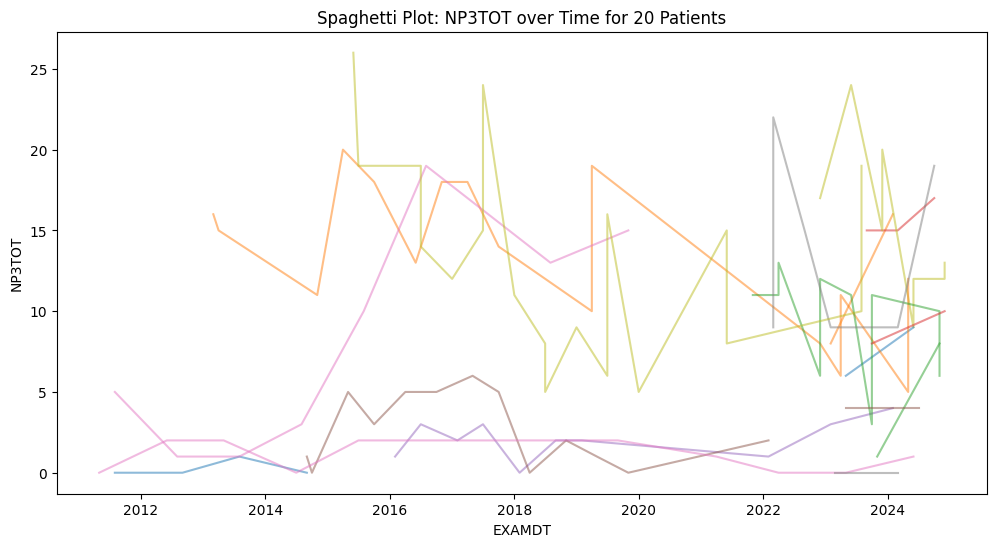

In [24]:
# 1. Spaghetti plot: NP3TOT over time for 20 random patients
plt.figure(figsize=(12, 6))
sample_patnos = np.random.choice(data['PATNO'].dropna().unique(), size=20, replace=False)
for patno in sample_patnos:
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    plt.plot(patient['EXAMDT'], patient['NP3TOT'], alpha=0.5, label=f'{patno}')
plt.xlabel('EXAMDT')
plt.ylabel('NP3TOT')
plt.title('Spaghetti Plot: NP3TOT over Time for 20 Patients')
plt.show()

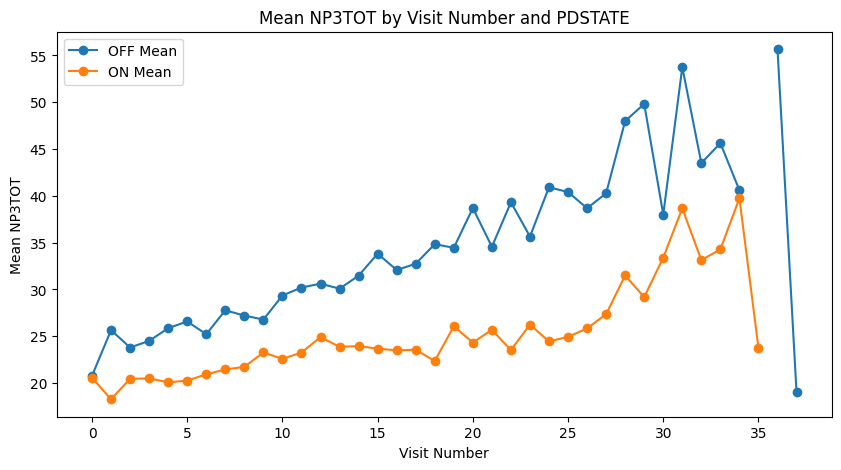

In [25]:
# 2. Mean/median trends by cohort and PDSTATE
plt.figure(figsize=(10, 5))
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

### Mean NP3TOT by Visit Number and PDSTATE

This analysis visualizes how **motor severity (NP3TOT)** changes over sequential visits, stratified by **PDSTATE** ("ON" vs. "OFF" medication).

### Method

- Data is grouped by **VISIT_NUM** and **PDSTATE** ("ON" or "OFF").
- For each group, the **mean NP3TOT** is calculated.
- The resulting trends are plotted over visit numbers, allowing comparison of **motor scores with vs. without medication** over time.

### Interpretation of the Plot

- **OFF state (blue line)**:
  - Patients assessed OFF medication have **consistently higher NP3TOT scores**, reflecting worse motor function.
  - The mean NP3TOT increases steadily from ~25 to **~55+** by visit 34, showing clear **disease progression** in the untreated state.
- **ON state (orange line)**:
  - Motor scores are consistently **lower** than OFF, with slower progression.
  - Starting near 20, they gradually rise toward 40, suggesting some worsening over time despite medication.
- The **gap between ON and OFF lines** remains fairly consistent, representing the **symptomatic benefit** of dopaminergic therapy.
- A sharp drop at the right end of both curves (visits 35–36) likely reflects **lower sample sizes** or **data sparsity**, not clinical improvement.

### Summary

- This plot reinforces that **ON medication consistently reduces motor severity scores** compared to OFF.
- Both groups show progression over time, but the ON group progresses more slowly, highlighting the **modifying effect of treatment**.
- These trends support the use of **PDSTATE-stratified models** to estimate medication effects and progression dynamics separately.

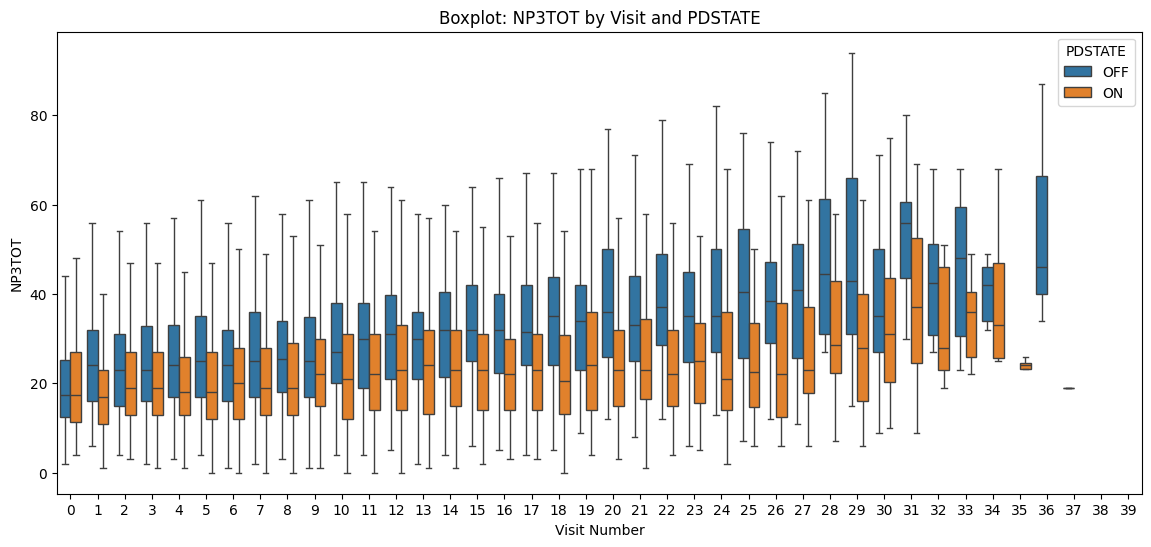

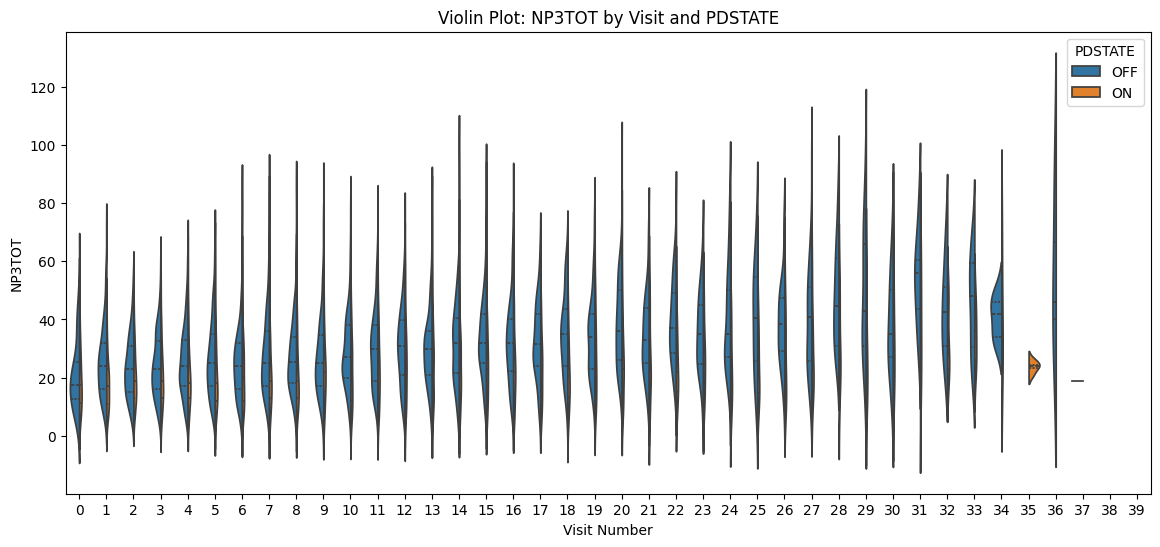

In [26]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

---

### Interpretation of Violin Plot: NP3TOT by Visit and PDSTATE

This violin plot extends the boxplot analysis by showing the **full distribution** of NP3TOT scores for each visit, stratified by **PDSTATE** ("ON" vs. "OFF").

#### Key Observations

- **OFF state (blue violins)**:
  - Generally wider and taller, indicating **greater variability** in motor scores.
  - As visit number increases, the shape of the violins shifts upward, with **higher density in upper score ranges**, consistent with **progressive worsening**.
  - Many violins show **bimodal or skewed** distributions in later visits, reflecting heterogeneous disease trajectories.

- **ON state (orange violins)**:
  - Present for most visits, but sparse or absent at later time points (e.g., visit 35+), suggesting **fewer ON assessments** late in follow-up.
  - Distributions are **narrower and shifted downward** compared to OFF, confirming the **consistent symptom-relieving effect** of medication.
  - Vertical compression suggests **less dispersion** in motor scores when ON medication, possibly due to therapeutic leveling.

#### Visual Benefits of Violin Plot

- Unlike boxplots, violins display the **underlying data density**, highlighting:
  - **Distribution asymmetry** (e.g., long tails).
  - **Multi-modal patterns**, which could indicate subpopulations or misclassification.
  - The **fading presence** of ON assessments in later visits, which may influence longitudinal analyses.

---

### Final Summary (Box + Violin Plots)

- Patients assessed OFF medication show **higher and more variable motor severity scores** across all visits.
- ON assessments are **more stable and consistently lower**, but still exhibit some progression.
- Both visualizations confirm that **PDSTATE stratification is crucial** when modeling NP3TOT over time.
- The increasing spread in OFF-state scores over time underscores the **growing heterogeneity** in advanced Parkinson’s disease, possibly driven by diverse progression rates, treatment responses, or dropout patterns.

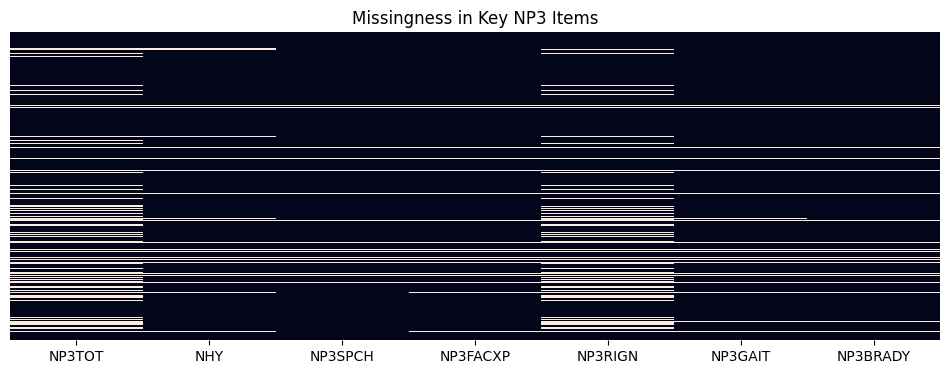

In [27]:
# 4. Heatmap: Missingness in key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
plt.figure(figsize=(12, 4))
sns.heatmap(data[key_items].isnull(), cbar=False, yticklabels=False)
plt.title('Missingness in Key NP3 Items')
plt.show()

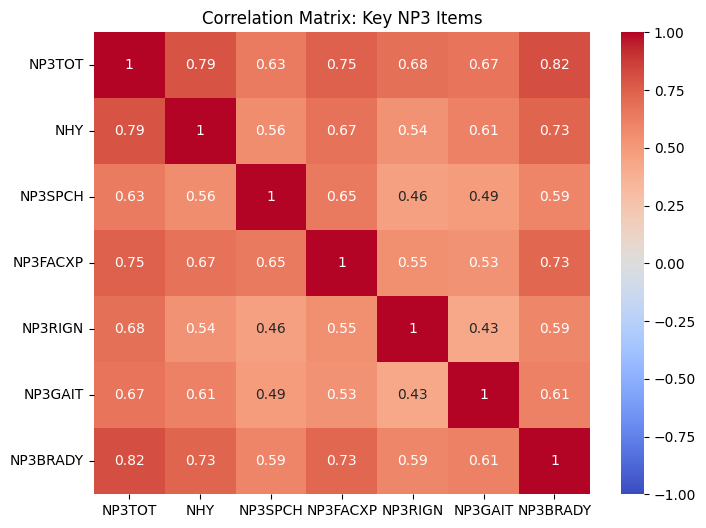

In [28]:
# 5. Heatmap: Correlation matrix for key NP3 items
corr_matrix = data[key_items].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key NP3 Items')
plt.show()